# 1 Wstęp

## 1.1 Wybór tematu
### Temat, który wybrałem do analizy opini, za pomocą technik przetwarzania tekstu, to UFC, a więc amerykańska federacja Mixed Martial Arts, czyli sportów walki. Gale sportowe odbywają się regularnie co miesiąc i oprócz tradycyjnych większych zawodów, między nimi pojawiają się również mniejsze gale pozwalające pokazać się mniej znanym zawodnikom. Tweetów i emocji miesięcznie jest na pewno bardzo dużo.
### Analizowane przeze mnie tweety pochodzą z okresu od 2022-09-01 do 2023-01-30 i postanowiłem pobierać po max 200 tweetów z każdego dnia.

# 2 Program do przetworzenia danych
## 2.1 Import paczek i załadowanie danych wejściowych

In [36]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd
import re
import text2emotion as te

def scrap():
    tweets = []

    hashtag = "#UFC"
    beginning_date = datetime.date(2022, 9, 1)
    end_date = date + datetime.timedelta(days=1)
    max_tweets_per_day = 200

    while date != datetime.date(2023, 1, 30):
        query = f'#{hashtag} since:{beginning_date} until:{end_date}'
        new_tweets = []
        for i, tweet in enumerate(sntwitter.TwitterHashtagScraper(query, maxEmptyPages=5).get_items()):
            new_tweets.append(tweet)

            if len(new_tweets) >= max_tweets_per_day:
                break
        tweets.extend(new_tweets)
        beginning_date += datetime.timedelta(days=1)
        end_date += datetime.timedelta(days=1)

    print("Number of scraped tweets:", len(tweets))

    df = pd.DataFrame(tweets)
    file_path = "ufc_data.csv"

    df.to_csv(file_path, sep='\t', index=False)

### 'Scrappowanie' danych trwało ponad godzinę, więc zapakowałem program w funkcję i zapisałem dane do pliku csv, który w następnym kroku odczytuję i poddaję wstępnej obróbce, zostawiając tylko potrzebne mi kolumny oraz tweety napisane w języku angielskim.

In [37]:
file_path = 'C:\infa\zajecia\\4 semestr\io\projekt3\\ufc_data.csv'

df = pd.read_csv(file_path, encoding='cp1250', delimiter=';')
df.drop(['url', 'rawContent', 'id', 'user', 'replyCount', 'retweetCount', 'likeCount', 'quoteCount', 'conversationId',
         'source',	'sourceUrl', 'sourceLabel',	'links', 'media', 'retweetedTweet', 'quotedTweet', 'inReplyToTweetId', 'inReplyToUser',
         'mentionedUsers', 'coordinates', 'place', 'hashtags', 'cashtags', 'card', 'viewCount', 'vibe', 'bookmarkCount'], axis=1, inplace=True)
df = df[(df['lang'] == 'en')]

## 2.2 Preprocessing danych
### W tym kroku za pomocą trzech pomocniczych funkcji przygotowuje dane do dalszej pracy. Przeprowadzam kroki dla Bag of Words, usuwam linki oraz usuwam z dat niepotrzebny mi dokładny czas wrzucenia wpisu.

In [38]:
def preprocess_text(text):
    tokens = word_tokenize(text.lower())    
    additional_stopwords = ['ufc', 'mma', 'danawhite', 'youtube', 'mmatwitter', 'fight', 'fighter', 'bst', '>', '<', 'ufc' '&', '#', '(', ')',
                            '.', ',', '\'', '?', '!', '``', 'â€', '"', '--', 'n\'t', "''", '“', '\'s', '@', 'et', 'pt', ':', 're']
    stopwords_list = stopwords.words('english') + additional_stopwords
    filtered_tokens = [token for token in tokens if token not in stopwords_list]
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    
    processed_text = ' '.join(lemmatized_tokens)
    return processed_text

def remove_url(string):
    return re.sub(r'http\S+|www\S+', '', string)

def strip_time(date_string):
    datetime_format = "%d.%m.%Y %H:%M"
    try:
        datetime_obj = datetime.datetime.strptime(date_string, datetime_format + ":%S")
    except ValueError:
        datetime_obj = datetime.datetime.strptime(date_string, datetime_format)
    date_only = datetime_obj.strftime("%d.%m.%Y")
    return date_only

df['renderedContent'] = df['renderedContent'].apply(lambda x: remove_url(x))
df['processed'] = df['renderedContent'].apply(lambda x: preprocess_text(x))
df['date'] = df['date'].apply(strip_time)

## 2.3 Biblioteka Vader
### Pierwszą z użytych bibliotek jest paczka NLTK Vader, która zwraca 3 wskaźniki nastawienia: pozytywny, negatywny, neutralny, a one wszystkie sumują się w pole 'compound', a więc łączna wartość z przedziału -1 do 1.

### 2.3.1 Analiza całościowa
#### Pierwszym etapem analizy nastawienia emocjonalnego autora będzie sprawdzenia wyrazów używanych w tweetach i zobrazowanie ich w 'WordCloudach'. Na początku przygotowuję dane analizując każdy z wpisów za pomocą klasyfikatora 'SentimentIntensityAnalyzer', a otrzymane dane dopisuje do nowo tworzonych kolumn. Wpis uważam za pozytywny, jeśli ocena 'compound' jest >= 0, a więc zaliczam do nich również te neutralne. W przeciwnym wypadku będzie on negatywny.

In [39]:

analyzer = SentimentIntensityAnalyzer()
df['vader'] = df['processed'].apply(lambda x: analyzer.polarity_scores(x))
df["vadNeg"] = df['vader'].apply(lambda x: x["neg"])
df["vadPos"] = df['vader'].apply(lambda x: x["pos"])
df["vadCompound"] = df['vader'].apply(lambda x: x["compound"])
df['vadSentiment'] = df['vader'].apply(lambda x: 'positive' if x['compound'] >= 0 else 'negative')

positive_string = df[df['vadSentiment'] == 'positive']['processed'].str.cat(sep=' ')
negative_string = df[df['vadSentiment'] == 'negative']['processed'].str.cat(sep=' ')

#### W kolejnym etapie tworzę 'WordCloudy' podzielone na tweety pozytywne i negatywne.

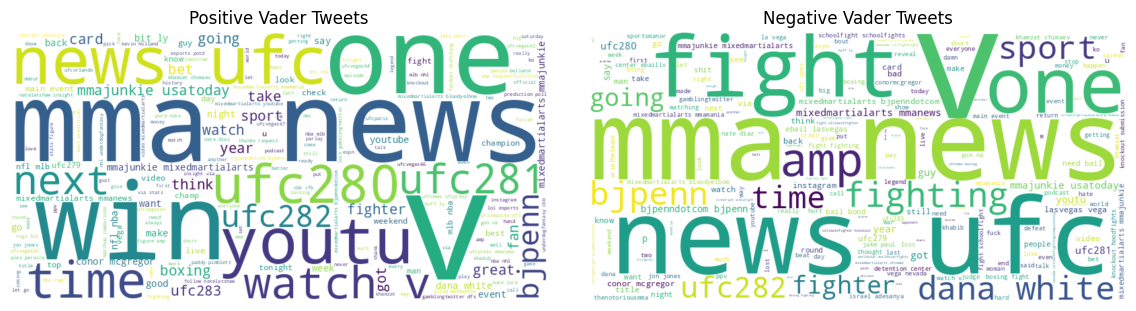

In [40]:
wordcloudPositive = WordCloud(width=800, height=400, background_color='white').generate(positive_string)
wordcloudNegative = WordCloud(width=800, height=400, background_color='white').generate(negative_string)
fig = plt.figure(figsize=(12, 12), facecolor=None)

plt.subplot(1, 2, 1)
plt.imshow(wordcloudPositive, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Vader Tweets')

plt.subplot(1, 2, 2)
plt.imshow(wordcloudNegative, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Vader Tweets')

plt.tight_layout(pad=3)
plt.show()

#### Jak widać wyżej obie chmury zawierają wiele podobnych wyrazów, mają natomiast też rożnice. W obu możemy odczytać słowa 'mma news', 'ufc', 'dana white' - właściciel federacji oraz co nie dziwi, odbywające się w wybranym okresie czasu gale UFC m.in 280, 281 oraz 282. Dodatkowo pozytywna chmurka zawiera słowa 'win', 'fan' lub 'still', gdzie negatywna z kolei przykładowo 'end', 'final', a nawet niecenzuralne słowa opisujące frustrację po przegranej idola.

### 2.3.2 Analiza czasowa
#### Tym razem zobrazuję średnie wskaźniki emocji w poszczególnych dniach w analizowanym okresie czasowym. 

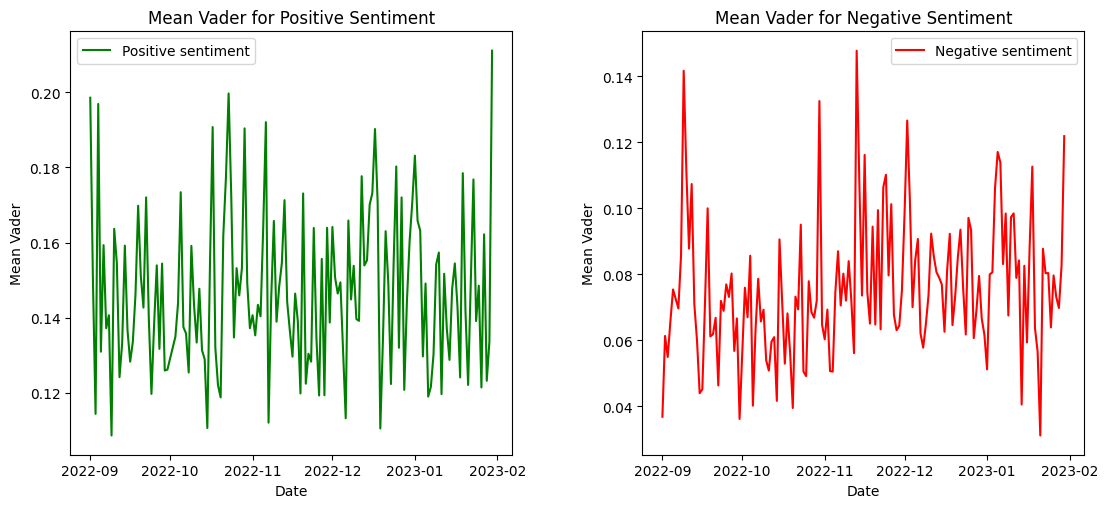

In [41]:
df["date"] = df.apply(lambda x: datetime.datetime.strptime(x["date"], "%d.%m.%Y").date(), axis=1)
df_vadGrouped = df[["date", "vadNeg", "vadPos", "vadCompound"]]
vadGroupedMeans = df_vadGrouped.groupby(["date"], as_index=False).mean()

plt.figure(figsize=(12, 6), facecolor=None)
plt.subplot(1, 2, 1)
plt.plot(vadGroupedMeans["date"], vadGroupedMeans['vadPos'], color='green', label="Positive sentiment")
plt.xlabel('Date')
plt.ylabel('Mean Vader')
plt.title('Mean Vader for Positive Sentiment')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(vadGroupedMeans["date"], vadGroupedMeans['vadNeg'], color='red', label="Negative sentiment")
plt.xlabel('Date')
plt.ylabel('Mean Vader')
plt.title('Mean Vader for Negative Sentiment')
plt.legend()

plt.tight_layout(pad=4)
plt.show()

#### Jak widać na wykresach obie emocje mocno się wahają. Pozytywne od wartości 0.12 do 0.20, negatywne natomiast od 0.04 do 0.14. Jest to prawdopodobnie zależne od odbywających się w tym czasie gal i wydarzeń z nią związanych.

## 2.4 Biblioteka Text2Emotion
### Druga z użytych bibliotek działa na podobnej zasadzie, zwracając jednak więcej wartości emocjonalnych. Jest to 5 wskaźników: 'Happy', 'Sad', 'Angry', 'Fear', 'Surprise'. Ponieważ analiza tą biblioteką trwa dość długo postanowiłem stworzyć osobną funkcję, a później odczytać dane z zapisanego pliku CSV i zapisać w dodawanych poszczególnych kolumnach.

In [42]:
def t2e_processing():
    tweets = df['processed'].apply(lambda x: te.get_emotion(x))
    df = pd.DataFrame(tweets)
    file_path = "t2e_data.csv"
    df.to_csv(file_path, sep='\t', index=False)

file_path2 = 'C:\infa\zajecia\\4 semestr\io\projekt3\\t2e_data.csv'
data = []
with open(file_path2, 'r') as file:
    for line in file:
        line_data = eval(line.strip())
        data.append(line_data)
        
df['t2e'] = data
df["t2eHappy"] = df.apply(lambda x: x["t2e"]["Happy"], axis=1)
df["t2eAngry"] = df.apply(lambda x: x["t2e"]["Angry"], axis=1)
df["t2eSurprise"] = df.apply(lambda x: x["t2e"]["Surprise"], axis=1)
df["t2eSad"] = df.apply(lambda x: x["t2e"]["Sad"], axis=1)
df["t2eFear"] = df.apply(lambda x: x["t2e"]["Fear"], axis=1)

### 2.4.1 Jak poprzednio, zacznę od analizy całościowej
#### Postanowiłem sprawdzić jak zmienią się chmury wyrazów jeśli zbadamy inne emocje, które oferuje biblioteka. Będą nimi: 'Angry' oraz 'Surprise'. Jeśli wartość wskaźnika przekracza 0.25 to uznaje wpis za odpowiedni, w przeciwnym wypadku ignoruje go, zapisując 'other'.

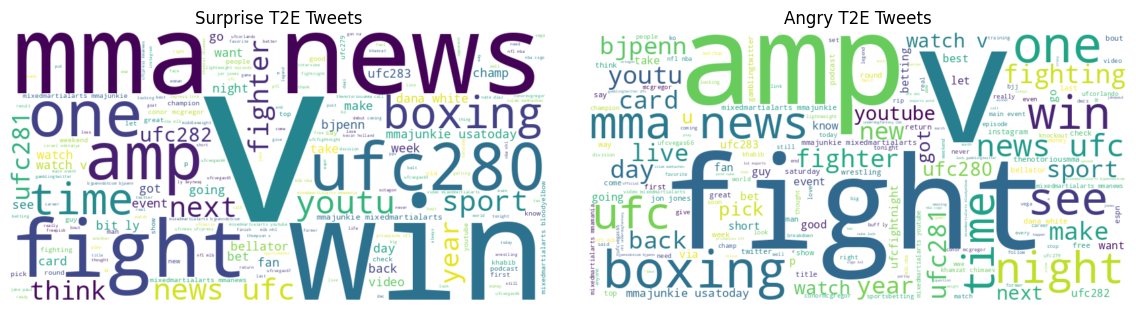

In [43]:
df['t2eSentiment'] = df['t2e'].apply(lambda x: 'surprise' if x['Surprise'] >= 0.25 else 'angry' if x['Angry'] >= 0.25 else 'other')
surprise_string = df[df['t2eSentiment'] == 'surprise']['processed'].str.cat(sep=' ')
angry_string = df[df['t2eSentiment'] == 'angry']['processed'].str.cat(sep=' ')

wordcloudSurprise = WordCloud(width=800, height=400, background_color='white').generate(surprise_string)
wordcloudAngry = WordCloud(width=800, height=400, background_color='white').generate(angry_string)

plt.figure(figsize=(12, 12), facecolor=None)
plt.subplot(1, 2, 1)
plt.imshow(wordcloudSurprise, interpolation='bilinear')
plt.axis('off')
plt.title('Surprise T2E Tweets')

plt.subplot(1, 2, 2)
plt.imshow(wordcloudAngry, interpolation='bilinear')
plt.axis('off')
plt.title('Angry T2E Tweets')

plt.tight_layout(pad=3)
plt.show()

#### Po raz kolejny z chmurek nie można odczytać wielu różnic. Ponownie widzimy wyrazy charakterystyczne dla sportów walki. W 'WordClaudzie' dla emocji złości widać wyrazy 'bet', 'betting'. Może to świadczyć o wyrzucanych emocjach użytkowników ze względu na porażkę obstawionego przez nich zawodnika. W chmurce 'Surprise' widzimy przykładowo słowo 'Champ' co może wskazywać na walkę o pas mistrzowski i niespodziewanego nowego '#1' w danej kategorii wagowej.

### 2.4.3 Analiza czasowa
#### W analizie czasowej na podstawie biblioteki Text2Emotion skupię się już na wszystkich wskaźnikach oferowanych przez bibliotekę. Grupuje otrzymane emocje według dat, a poźniej na wykresach przedstawiam każdą z nich na przestrzeni analizowanego okresu czasowego.

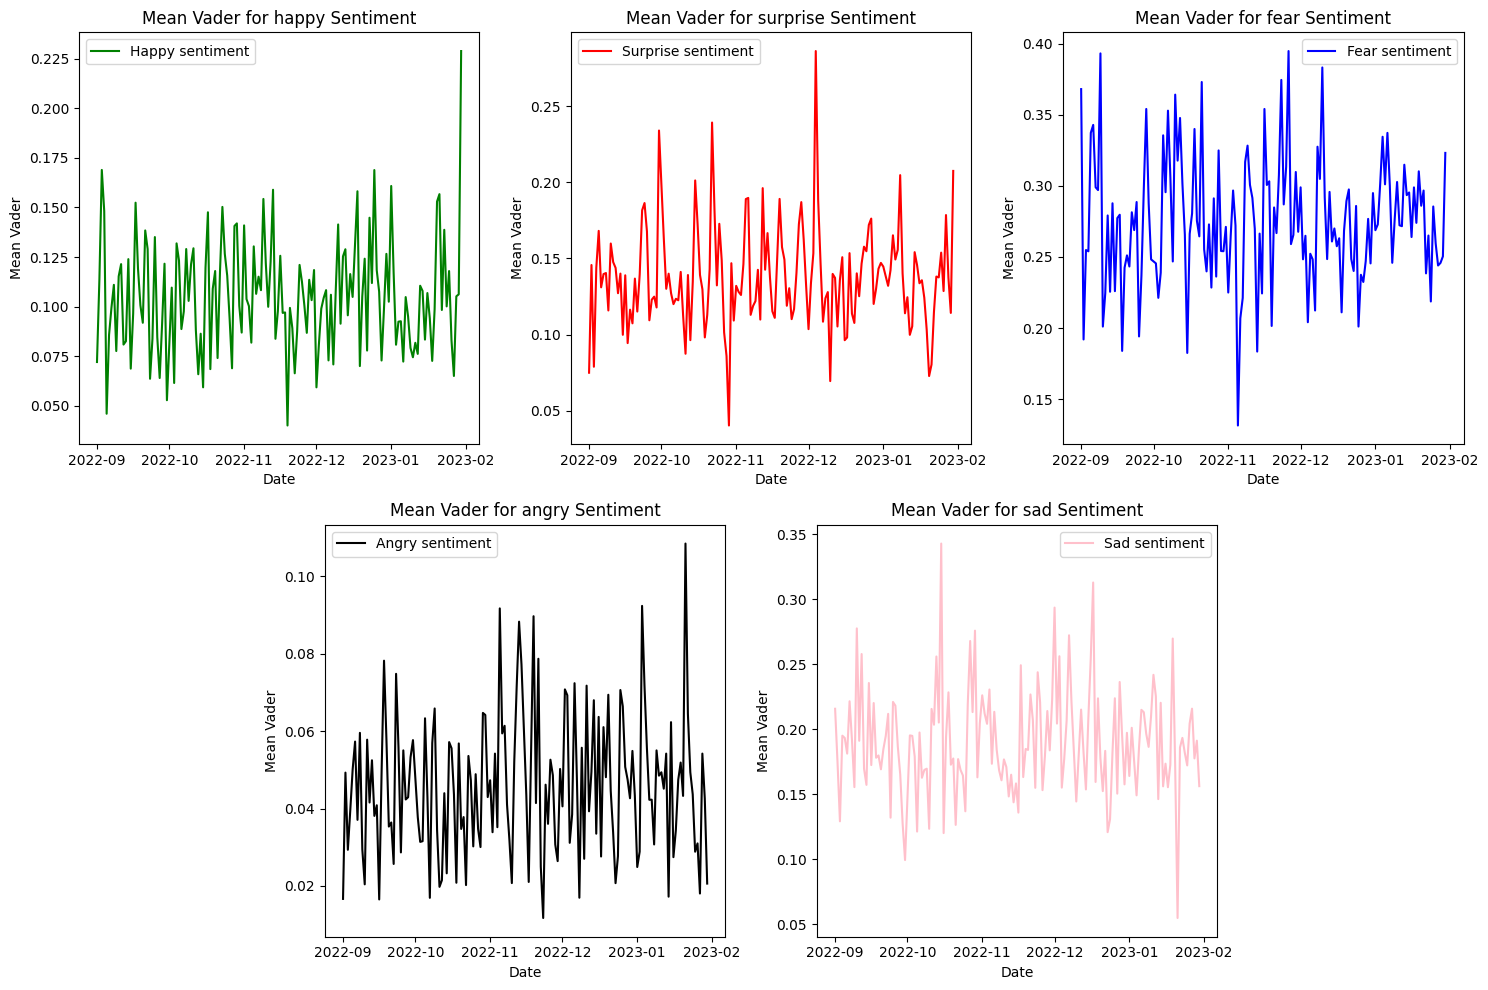

In [44]:
df_t2eGrouped = df[["date", "t2eHappy", "t2eSurprise", "t2eFear", "t2eAngry", "t2eSad"]]

t2eGroupedMeans = df_t2eGrouped.groupby(["date"], as_index=False).mean()

plt.figure(figsize=(15, 10))
plt.subplot2grid((2, 6), (0, 0), colspan=2)
plt.plot(t2eGroupedMeans["date"], t2eGroupedMeans['t2eHappy'], color='green', label="Happy sentiment")
plt.xlabel('Date')
plt.ylabel('Mean Vader')
plt.title('Mean Vader for happy Sentiment')
plt.legend()

plt.subplot2grid((2, 6), (0, 2), colspan=2)
plt.plot(t2eGroupedMeans["date"], t2eGroupedMeans['t2eSurprise'], color='red', label="Surprise sentiment")
plt.xlabel('Date')
plt.ylabel('Mean Vader')
plt.title('Mean Vader for surprise Sentiment')
plt.legend()

plt.subplot2grid((2, 6), (0, 4), colspan=2)
plt.plot(t2eGroupedMeans["date"], t2eGroupedMeans['t2eFear'], color='blue', label="Fear sentiment")
plt.xlabel('Date')
plt.ylabel('Mean Vader')
plt.title('Mean Vader for fear Sentiment')
plt.legend()

plt.subplot2grid((2, 6), (1, 1), colspan=2)
plt.plot(t2eGroupedMeans["date"], t2eGroupedMeans['t2eAngry'], color='black', label="Angry sentiment")
plt.xlabel('Date')
plt.ylabel('Mean Vader')
plt.title('Mean Vader for angry Sentiment')
plt.legend()

plt.subplot2grid((2, 6), (1, 3), colspan=2)
plt.plot(t2eGroupedMeans["date"], t2eGroupedMeans['t2eSad'], color='pink', label="Sad sentiment")
plt.xlabel('Date')
plt.ylabel('Mean Vader')
plt.title('Mean Vader for sad Sentiment')
plt.legend()

plt.tight_layout()
plt.show()


#### Największe skoki wskaźników widać bez wątpienia w negatywnych emocjach. Emocje 'Sad' i 'Fear' wahają się od 0.05 do aż 0.40. Po raz kolejny widzimy wysokie skoki emocjonalne, po czym powrót do uśrednionej wartości. Czas między galami wskazuje prawdopodbnie średnią, a skoki spowodowane są emocjami związanymi z wydarzeniami.

## 3 Podsumowanie i bibliografia
### Jak widać w powyższych doświadczeniach wydarzenia są nierozłącznie powiązane ze skokami emocji wśród użytkowników. Analiza całościowa dała pogląd na to jakich słów używa się w tweetach otagowanych #UFC, a analiza czasowa, pokazała jak zmieniają się emocje na przestrzeni czasu i co wpływa na skoki temperatury wśród użytkowników tweetera.

## Bibliografia:
### https://www.nltk.org/_modules/nltk/sentiment/vader.html
### https://pypi.org/project/text2emotion/
### https://pandas.pydata.org/
### https://matplotlib.org/stable/index.html